# RatU Day4SD recording info
- No timestamps were deleted after concatenating .dat files from various folders of open-ephys

In [1]:
import numpy as np
import subjects

sess = subjects.nsd.ratUday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.xml 
# channels: 192
sampling rate: 30000
lfp Srate (downsampled): 1250


In [ ]:
sess.neurons.get_neuron_type('pyr').n_neurons

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(sess.position.x,sess.position.y)

# Set probe configuration
- RatU_Day2NSD has two probes: both 128chan-8shanks diagnostic biochips.
- 64 channels in one of the probes (implanted in left hemisphere) had no signal from 4 shanks (probably one of the intan chips was faulty). So only 192 channels were recorded, the channels in .dat file are already order according to depth.


In [ ]:
%matplotlib inline
from neuropy.core import shank, probe, probegroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- diagnostic-biochip 8 shanks -----------
for i in range(8):
    chans = channel_groups[i]
    shank = shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0,-7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = probe(shanks)

#--- dignostic biochip 4 shanks (4 shanks were bad) ----------- 
shanks = []
for i in range(8,12):

    shank = shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = probegroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.filename = sess.fileprefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)

## Writing to json format for spyking-circus 

In [ ]:
from neuropy.utils import probe_util

file = sess.filePrefix.with_suffix('.prb')
probe_util.write_spyking_circus(file,sess.probegroup,shanksCombine=True)


# Create experimental paradigm
- pre sleep is a little shorter
- animal was lazy on re-maze

In [ ]:
sess.paradigm.to_dataframe()

In [ ]:
import pandas as pd
from neuropy.core import Epoch

datetime_data = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
durations = datetime_data.nFrames/sess.recinfo.dat_sampling_rate
epochs = pd.DataFrame(
    {
        "start": [0,9545,12856,45317],
        "stop": [9544,12855,45316,48496],
        "label": ["pre", "maze", "post",'re-maze'],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.filename = sess.filePrefix.with_suffix(".paradigm.npy")
paradigm.save()


In [ ]:
durations

In [ ]:
1313+3071+5160+3311+32461+3180

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
%matplotlib widget
from neuropy.analyses import detect_artifact_epochs
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.core import Signal
print(sess)
signal = sess.eegfile.get_signal([23,155])
# filt_trace = signal_process.filter_sig.highpass(signal.traces,cutoff=400)
# filtered_signal = Signal(np.median(filt_trace,axis=0).reshape((1,-1)),signal.sampling_rate)
artifact_epochs = detect_artifact_epochs(signal, thresh=10)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
# plotting.plot_artifact_epochs(artifact_epochs,sess.eegfile.get_signal([175]),downsample_factor=5)


In [ ]:
sess.artifact.to_dataframe()

### write artifact to neuroscope

In [ ]:

sess.recinfo.write_epochs(sess.artifact,ext='.art')

### write artifact epochs to spyking circus format

In [ ]:
from neuropy.io import SpykingCircusIO

file = sess.filePrefix.with_suffix('.dead')
SpykingCircusIO.write_epochs(file,sess.artifact)

## Sleep scoring

In [ ]:
from neuropy.core import Signal
from neuropy.analyses import brainstates

signal = sess.eegfile.get_signal() 
brainstates = brainstates.detect_brainstates_epochs(signal=signal,probe=sess.probegroup)

In [ ]:
brainstates.filename = sess.filePrefix.with_suffix('.brainstates')
brainstates.save()

## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Neurons

## Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path("/home/bapung/Documents/ClusteringHub/spykcirc/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38-1.GUI")
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id<4] = 'pyr'
neuron_type[neuron_type_id==6] = 'mua'
neuron_type[neuron_type_id==8] = 'inter'


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=neuron_type,
    metadata={'cluster_path':cluster_path}
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Position
- concatenated .dat file did not have any deleted timepoints

## Import position from optitrack

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=0.25)

## Align position with .dat file

In [ ]:
import pandas as pd
from datetime import datetime

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    # sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S")
    # + pd.Timedelta(sync_time,unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)

In [ ]:
rec_datetime['sync_nframes']/rec_datetime['sync_rate']

In [ ]:
position.filename = sess.filePrefix.with_suffix('.position.npy')
position.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(sess.position.y,sess.position.x)

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([40])

spec = signal_process.SpectrogramBands(signal)


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/500)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.y)*100)
# plt.xlim([12500,12600])
plt.ylim([-400,400])

## Linearize position

In [ ]:
from neuropy.utils import position_util

maze = sess.paradigm['maze']
maze_position = sess.position.time_slice(maze[0],maze[1])
lin_pos = position_util.linearize_position(maze_position,sigma=10)

lin_pos.filename = sess.filePrefix.with_suffix('.linearized_maze')
lin_pos.save()

## Checking position alignment with .dat file
- Comparing theta power, speed and position to check if high theta periods are correlated with the speed of the animal

In [2]:
%matplotlib widget
from neuropy.utils import signal_process
maze= sess.paradigm['maze']
signal = sess.eegfile.get_signal(107,t_start=maze[0],t_stop=maze[1])
spec = signal_process.SpectrogramBands(signal,window=0.2,overlap=0.1)

In [17]:
from neuropy.utils import signal_process
from scipy import stats
freqs = np.arange(1,20,0.5)
wavdec = signal_process.wavelet_decomp(stats.zscore(signal.traces[0]),sampfreq=1250,freqs=freqs)

wvlt_power = wavdec.colgin2009()

In [15]:
wavdec.freqs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
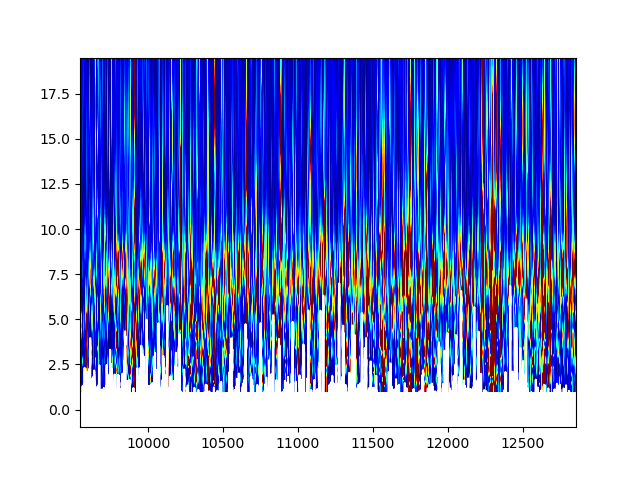

In [24]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.imshow(wvlt_power,aspect='auto',cmap='jet',vmax=80000,extent=[signal.t_start,signal.t_stop,wavdec.freqs[0],wavdec.freqs[-1]],origin='lower')
plt.plot(pos_t,speed/10,'w')

In [27]:
indx = np.where((wavdec.freqs>=4)&(wavdec.freqs<=12))[0]
theta_wvlt_power = np.median(wvlt_power[indx,:],axis=0)

(-400.0, 400.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
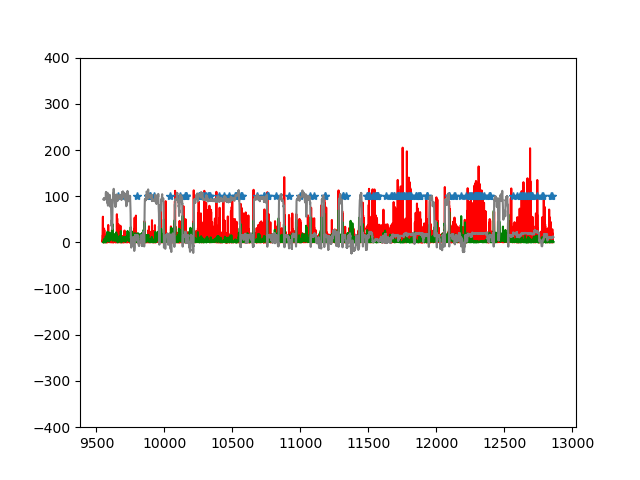

In [36]:
%matplotlib widget
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

position = sess.position.time_slice(maze[0],maze[1])
rpls = sess.ripple.time_slice(maze[0],maze[1]).starts
x = position.x[:-1]
# y = position.y[:-1]
pos_t = position.time[:-1]+6
speed = gaussian_filter1d( position.speed,sigma =20)
theta = np.interp(pos_t,spec.time,spec.theta)
theta = gaussian_filter1d(theta,sigma=20)


# plt.plot(pos_t,theta/1800,'r')
# plt.plot(sess.position.time,sess.position.y)
plt.plot(signal.time,theta_wvlt_power/4000,'r')
plt.plot(rpls,100*np.ones_like(rpls),'*')
plt.plot(pos_t,speed,'g')
plt.plot(pos_t,x,'gray')
# plt.plot(pos_t,y,'k')
# plt.plot(sess.position.time[1:],np.diff(sess.position.x)*100)
# plt.xlim([1500,1600])
plt.ylim([-400,400])

In [ ]:
position.filename = sess.filePrefix.with_suffix('.maze.linear')
position.t_start = position.t_start +6
position.save()

In [ ]:
%matplotlib widget
import scipy.signal as sg

xcorr = sg.correlate(theta,speed,mode='same')
lags= sg.correlation_lags(len(pos_t),len(pos_t),mode='same')

plt.plot(lags/position.sampling_rate,xcorr)
# plt.xlim([-20,20])


